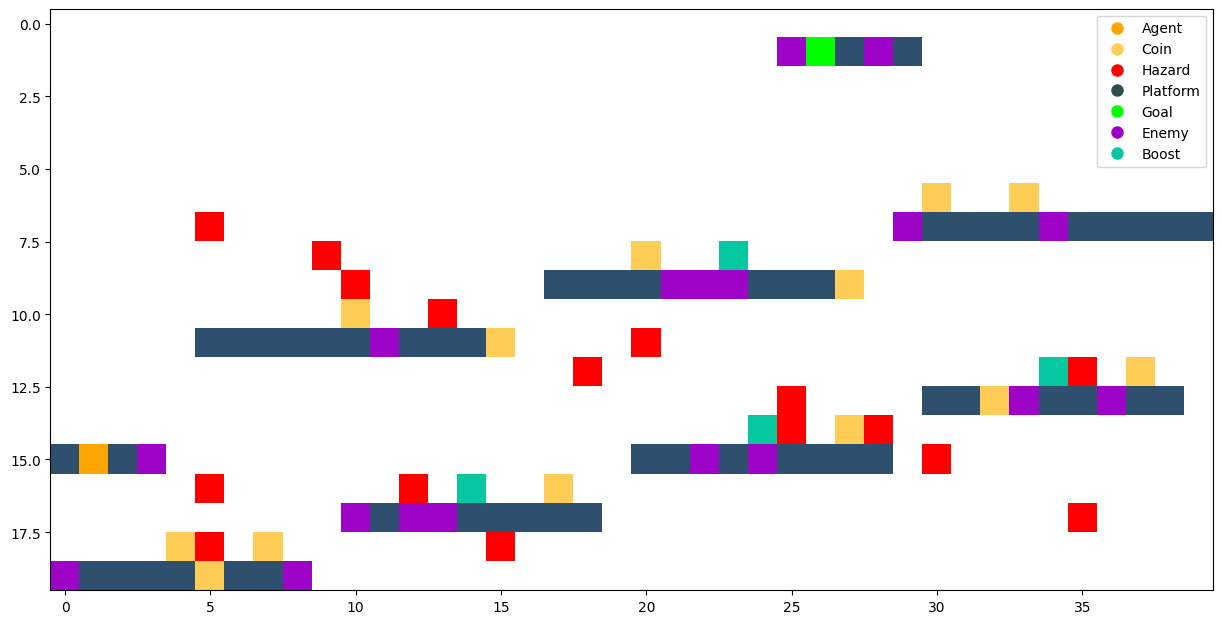

In [28]:

import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import colors


class ComplexPlatformEnv:
    def __init__(self, grid_size=(20, 40), goal_reward=500, coin_reward=60, hazard_penalty=-10, fall_penalty=-300, enemy_penalty=-15, boost_reward=10, survival_reward=-1):
        self.grid_size = grid_size
        self.goal_reward = goal_reward
        self.coin_reward = coin_reward
        self.hazard_penalty = hazard_penalty
        self.fall_penalty = fall_penalty
        self.enemy_penalty = enemy_penalty
        self.turn_reward = survival_reward
        self.boost_reward = boost_reward
        self.gravity = 1
        self.jump_strength = 3
        self.platforms = [(19, 0, 8), (17, 10, 18), (15, 20, 28), (13, 30, 38), (11, 5, 15), (9, 17, 27), (7, 29, 39),(1,25,29),(15,0,3)]
        self.dynamic_hazards = [(18, 5), (16, 12), (14, 25), (12, 35)]
        self.boosts = [(16, 14), (14, 24), (12, 34),(8,23)]
        self.reset()

    def reset(self):
        self.agent_pos = [15, 1]
        self.agent_velocity = 0
        self.coins = [(18, 4), (16, 14), (14, 24), (12, 34), (10, 10), (8, 20), (6, 30), (18, 7), (16, 17), (14, 27), (12, 37), (10, 13), (8, 23), (6, 33), (19, 5), (17, 12), (15, 22), (13, 32), (11, 15), (9, 27)]
        self.hazards = [(8, 9), (10, 13), (12, 18), (14, 28), (16, 5), (18, 15), (7, 5), (9, 10), (11, 20), (13, 25), (15, 30), (17, 35)]
        self.dynamic_hazards = [(18, 5), (16, 12), (14, 25), (12, 35)]
        self.goal_position = (1,26)
        self.enemies = self._place_enemies_on_platforms()
        self.done = False
        return self._get_state()

    def _place_enemies_on_platforms(self):
        enemies = []
        np.random.seed(101)
        for platform in self.platforms:
            row, start_col, end_col = platform
            num_enemies = random.randint(1, 3)
            for _ in range(num_enemies):
                col = random.randint(start_col, end_col)
                enemies.append((row, col))
        return enemies

    def _get_state(self):
        state = (self.agent_pos[0], self.agent_pos[1], self.agent_velocity)
        return state

    def _apply_gravity(self):
        if not self._on_platform(self.agent_pos) and self.agent_pos[0] < self.grid_size[0] - 1:
            self.agent_velocity += self.gravity
            base = min(self.agent_pos[0] + self.agent_velocity, self.grid_size[0] - 1)
            for i in range(self.agent_pos[0], base):
                if self._on_platform(pos=[i, self.agent_pos[1]]):
                    base = i
                    break
            self.agent_pos[0] = base
        else:
            self.agent_velocity = 0

    def _on_platform(self, pos):
        for platform in self.platforms:
            row, start_col, end_col = platform
            if pos[0] == row and start_col <= pos[1] <= end_col:
                return True
        return False

    def _move_hazards(self):
        for i, (row, col) in enumerate(self.dynamic_hazards):
            new_col = (col + 1) % self.grid_size[1]
            self.dynamic_hazards[i] = (row, new_col)

    def _move_enemies(self):
        for i, (row, col) in enumerate(self.enemies):
            direction = 1 if i % 2 == 0 else -1
            new_col = col + direction
            if new_col >= self.grid_size[1] or new_col < 0:
                new_col = col
            self.enemies[i] = (row, new_col)

    def _kill_enemies(self):
        surrounding_positions = [
            (self.agent_pos[0] + dy, self.agent_pos[1] + dx)
            for dy in [-1, 0, 1]
            for dx in [-1, 0, 1]
            if (dy != 0 or dx != 0)  # Exclude the agent's own position
        ]
        killed_enemies = []
        for pos in surrounding_positions:
            if pos in self.enemies:
                killed_enemies.append(pos)
        for enemy in killed_enemies:
            self.enemies.remove(enemy)
        return len(killed_enemies) * self.enemy_penalty  # Reward for killing enemies

    def step(self, action):
        if self.done:
            raise Exception("Game is over. Call reset() to start again.")
        reward = self.turn_reward
        if action == 0:  # Move left
            self.agent_pos[1] = max(self.agent_pos[1] - 1, 0)
        elif action == 1:  # Move right
            self.agent_pos[1] = min(self.agent_pos[1] + 1, self.grid_size[1] - 1)
        elif action == 2:  # Jump (only if on platform)
            if self._on_platform(self.agent_pos):
                self.agent_velocity = -self.jump_strength
                self.agent_pos[0] = max(self.agent_pos[0] + self.agent_velocity, 0)
        elif action == 3:  # Kill enemies around
            reward -= self._kill_enemies()

        self._apply_gravity()
        self._move_hazards()
        self._move_enemies()

        if tuple(self.agent_pos) == self.goal_position:
            reward += self.goal_reward
            self.done = True
        elif tuple(self.agent_pos) in self.coins:
            reward += self.coin_reward
            self.coins.remove(tuple(self.agent_pos))
        elif tuple(self.agent_pos) in self.hazards or tuple(self.agent_pos) in self.dynamic_hazards:
            reward += self.hazard_penalty
        elif tuple(self.agent_pos) in self.enemies:
            reward += self.enemy_penalty
        elif tuple(self.agent_pos) in self.boosts:
            reward += self.boost_reward
            self.jump_strength+=1
            self.boosts.remove(tuple(self.agent_pos))
        elif self.agent_pos[0] == self.grid_size[0] - 1:
            reward += self.fall_penalty
            self.done = True

        return self._get_state(), reward, self.done

    def render(self):
        grid = np.zeros(self.grid_size)

        for platform in self.platforms:
            row, start_col, end_col = platform
            grid[row, start_col:end_col + 1] = 1
        for coin in self.coins:
            grid[coin] = 3  # Coins
        for hazard in self.hazards:
            grid[hazard] = 2  # Static hazards
        for d_hazard in self.dynamic_hazards:
            grid[d_hazard] = 2  # Dynamic hazards
        for enemy in self.enemies:
            grid[enemy] = 6  # Enemies
        for boost in self.boosts:
            grid[boost] = 5  # Boosts
        grid[self.goal_position] = 4  # Goal
        grid[tuple(self.agent_pos)] = 7  # Agent

        cmap = colors.ListedColormap(['#ffffff', '#2f4f6f', '#ff0000', '#ffcc55', '#00ff00', '#05c8a1', '#9e04c8', '#ffa500'])
        bounds = [0, 1, 2, 3, 4, 5, 6, 7, 8]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(grid, cmap=cmap, norm=norm)

        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffa500', markersize=10, label='Agent'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ffcc55', markersize=10, label='Coin'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff0000', markersize=10, label='Hazard'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#2f4f4f', markersize=10, label='Platform'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#00ff00', markersize=10, label='Goal'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#9e04c8', markersize=10, label='Enemy'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#05c8a1', markersize=10, label='Boost'),
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.show()

env = ComplexPlatformEnv()
state = env.reset()
env.render()


Episode 1000: Total Reward: -513
Episode 2000: Total Reward: -332
Episode 3000: Total Reward: -521
Episode 4000: Total Reward: -285
Episode 5000: Total Reward: -364
Episode 6000: Total Reward: -271
Episode 7000: Total Reward: -294
Episode 8000: Total Reward: -540
Episode 9000: Total Reward: -467
Episode 10000: Total Reward: -423
Episode 11000: Total Reward: -311
Episode 12000: Total Reward: -375
Episode 13000: Total Reward: -666
Episode 14000: Total Reward: -332
Episode 15000: Total Reward: -317
Episode 16000: Total Reward: -265
Episode 17000: Total Reward: -315
Episode 18000: Total Reward: -294
Episode 19000: Total Reward: -357
Episode 20000: Total Reward: -375
Episode 21000: Total Reward: -284
Episode 22000: Total Reward: -341
Episode 23000: Total Reward: -256
Episode 24000: Total Reward: -211
Episode 25000: Total Reward: -375
Episode 26000: Total Reward: -202
Episode 27000: Total Reward: -256
Episode 28000: Total Reward: -275
Episode 29000: Total Reward: -322
Episode 30000: Total Re

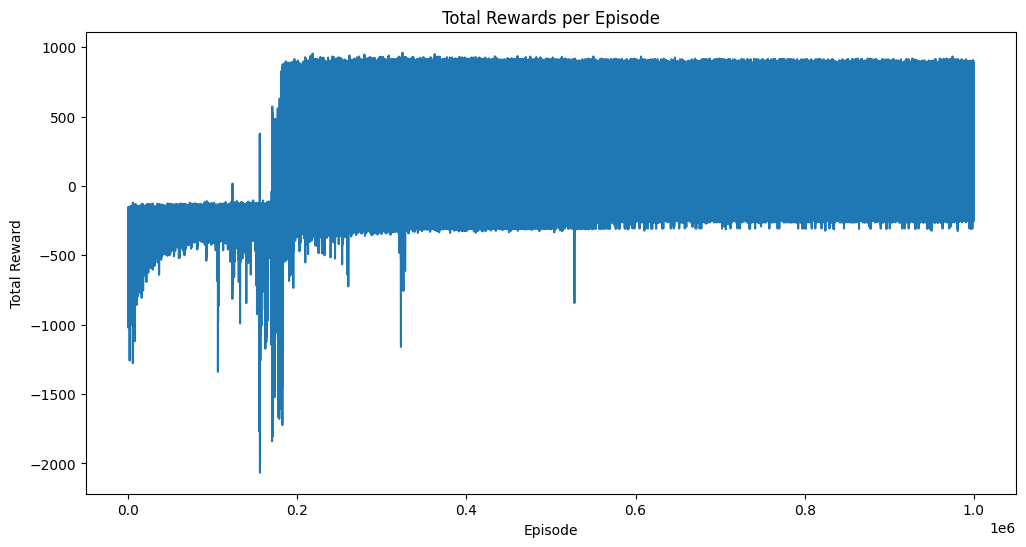

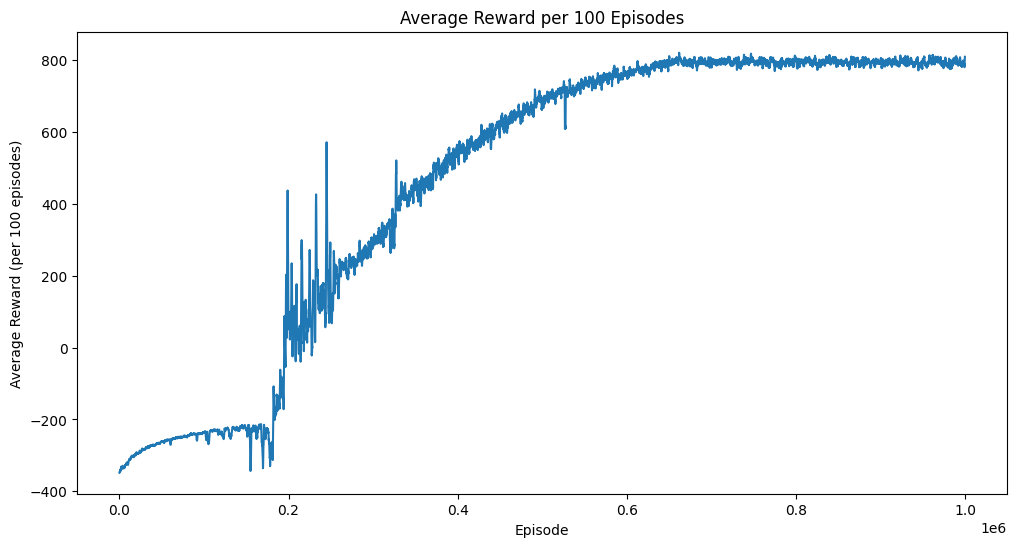

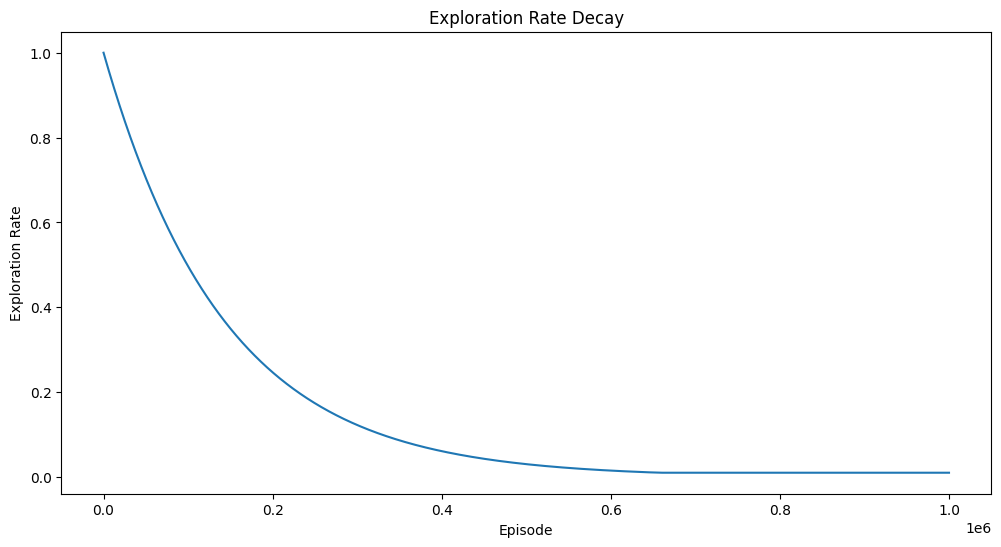

Final Total Reward: 883
Max Reward attained: 960
Average Reward: 463.658097
Average Reward(Last 1000 episodes): 789.415
Standard deviation(Last 1000 episodes):249.79071394869746
Q-table saved to final_q_values.pkl
Rewards saved to rewards_per_episode.pkl


In [29]:
from collections import defaultdict
import pickle
import time


class QLearningAgent:
    def __init__(
        self,
        env,
        learning_rate=0.08,
        discount_factor=0.90,
        exploration_rate=1.0,
        exploration_decay=0.999993,
        min_exploration_rate=0.01,
    ):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table = defaultdict(
            lambda: np.zeros(4)
        )  # Initialize Q-table with zeros for 4 actions
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = (
            reward + self.discount_factor * self.q_table[next_state][best_next_action]
        )
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(
                self.min_exploration_rate,
                self.exploration_rate * self.exploration_decay,
            )

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Rewards per Episode")
        plt.show()

        avg_rewards = [
            np.mean(self.rewards_per_episode[i : i + 1000])
            for i in range(0, len(self.rewards_per_episode), 100)
        ]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Average Reward (per 100 episodes)")
        plt.title("Average Reward per 100 Episodes")
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate")
        plt.title("Exploration Rate Decay")
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)
        avg_last=np.mean(self.rewards_per_episode[-1000:])
        max_reward = np.max(self.rewards_per_episode)
        std_dev=np.std(self.rewards_per_episode[-1000:])

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Max Reward attained: {max_reward}")
        print(f"Average Reward: {average_reward}")
        print(f"Average Reward(Last 1000 episodes): {avg_last}")
        print(f"Standard deviation(Last 1000 episodes):{std_dev}")

    def save_q_table(self, filename="q_table.pkl"):
        with open(filename, "wb") as file:
            pickle.dump(
                dict(self.q_table), file
            )  # Convert defaultdict to regular dict for saving
        print(f"Q-table saved to {filename}")

    def save_rewards(self, filename="rewards.pkl"):
        with open(filename, "wb") as file:
            pickle.dump(self.rewards_per_episode, file)
        print(f"Rewards saved to {filename}")


env = ComplexPlatformEnv()
agent = QLearningAgent(env)
agent.train(episodes=1000000)
agent.plot_performance()
agent.save_q_table("final_q_values.pkl")
agent.save_rewards("rewards_per_episode.pkl")

Episode 1000: Total Reward: -366
Episode 2000: Total Reward: -343
Episode 3000: Total Reward: -439
Episode 4000: Total Reward: -194
Episode 5000: Total Reward: -326
Episode 6000: Total Reward: -440
Episode 7000: Total Reward: -288
Episode 8000: Total Reward: -311
Episode 9000: Total Reward: -221
Episode 10000: Total Reward: -298
Episode 11000: Total Reward: -225
Episode 12000: Total Reward: -316
Episode 13000: Total Reward: -324
Episode 14000: Total Reward: -246
Episode 15000: Total Reward: -422
Episode 16000: Total Reward: -316
Episode 17000: Total Reward: -523
Episode 18000: Total Reward: -288
Episode 19000: Total Reward: -262
Episode 20000: Total Reward: -382
Episode 21000: Total Reward: -282
Episode 22000: Total Reward: -254
Episode 23000: Total Reward: -334
Episode 24000: Total Reward: -487
Episode 25000: Total Reward: -231
Episode 26000: Total Reward: -357
Episode 27000: Total Reward: -235
Episode 28000: Total Reward: -292
Episode 29000: Total Reward: -372
Episode 30000: Total Re

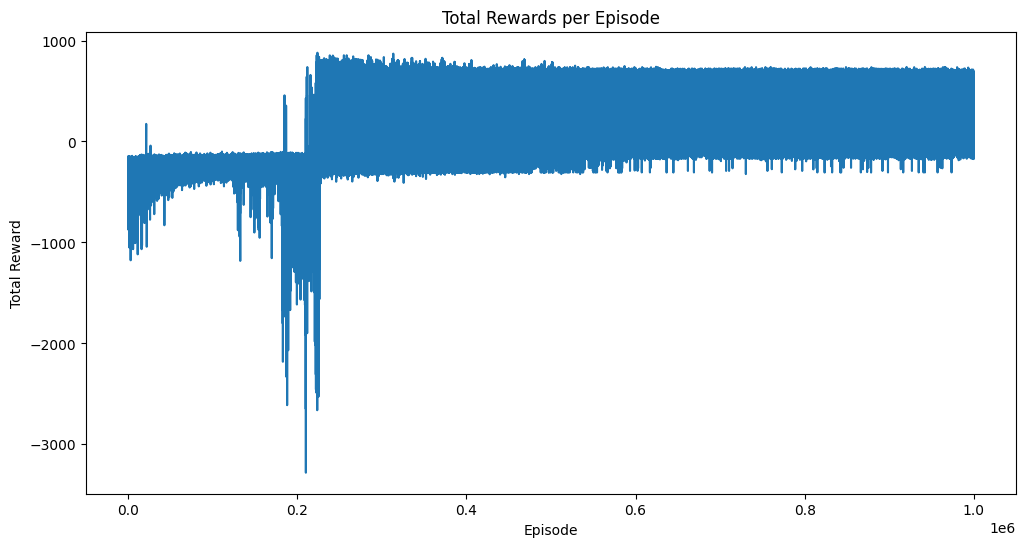

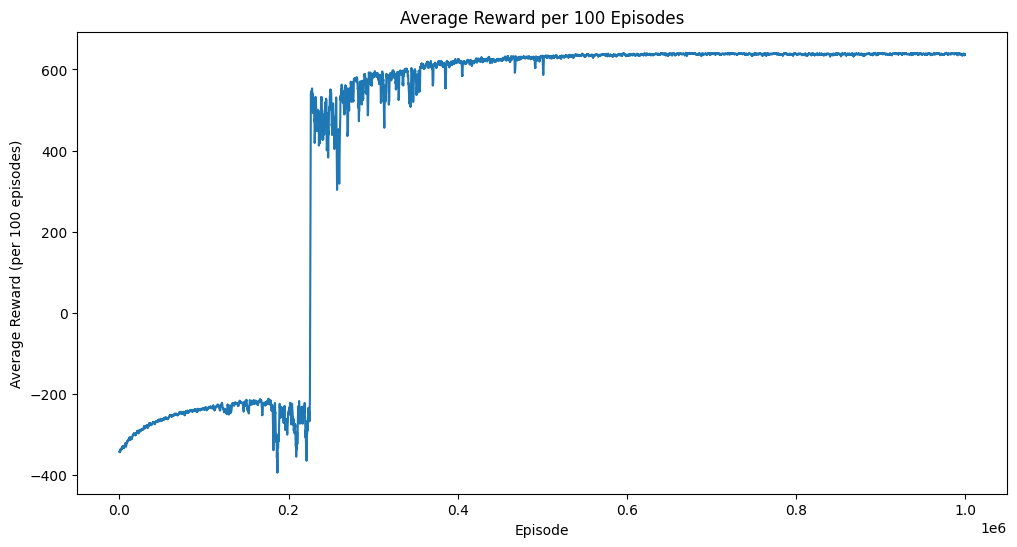

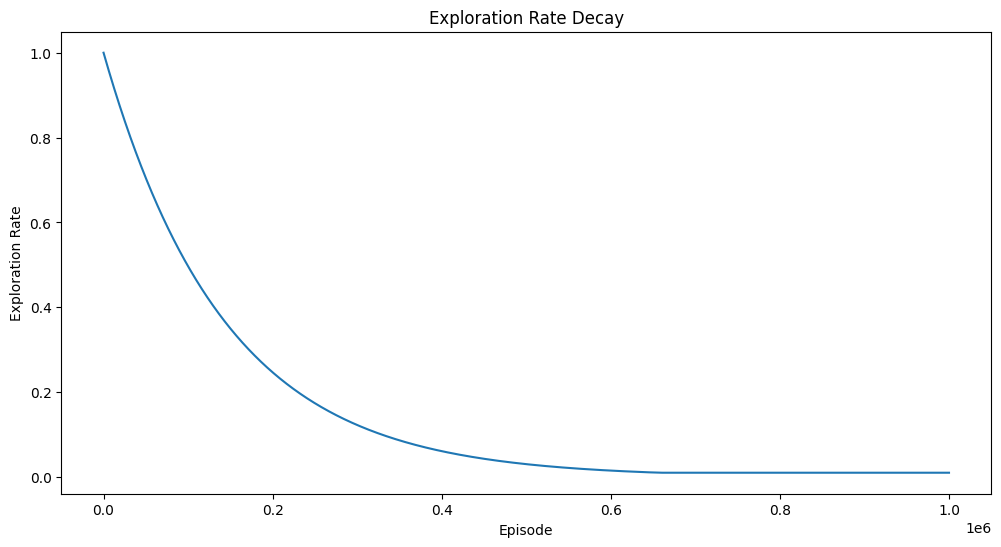

Final Total Reward: 640
Max Reward attained: 879
Average Reward: 419.442759
Average Reward(Last 1000 episodes): 635.474
Standard deviation(Last 1000 episodes):58.79865069880431


In [30]:
class DoubleQLearningAgent:
    def __init__(
        self,
        env,
        learning_rate=0.08,
        discount_factor=0.90,
        exploration_rate=1.0,
        exploration_decay=0.999993,
        min_exploration_rate=0.01,
    ):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(4))
        self.q_table2 = defaultdict(lambda: np.zeros(4))
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])
        else:
            q_values = self.q_table1[state] + self.q_table2[state]
            return np.argmax(q_values)

    def update_q_tables(self, state, action, reward, next_state):
        if random.random() < 0.5:
            best_next_action = np.argmax(self.q_table2[next_state])
            td_target = (
                reward
                + self.discount_factor * self.q_table2[next_state][best_next_action]
            )
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(self.q_table1[next_state])
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(
                self.min_exploration_rate,
                self.exploration_rate * self.exploration_decay,
            )

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Rewards per Episode")
        plt.show()

        avg_rewards = [
            np.mean(self.rewards_per_episode[i : i + 1000])
            for i in range(0, len(self.rewards_per_episode), 100)
        ]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Average Reward (per 100 episodes)")
        plt.title("Average Reward per 100 Episodes")
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate")
        plt.title("Exploration Rate Decay")
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)
        avg_last = np.mean(self.rewards_per_episode[-1000:])
        max_reward = np.max(self.rewards_per_episode)
        std_dev = np.std(self.rewards_per_episode[-1000:])

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Max Reward attained: {max_reward}")
        print(f"Average Reward: {average_reward}")
        print(f"Average Reward(Last 1000 episodes): {avg_last}")
        print(f"Standard deviation(Last 1000 episodes):{std_dev}")


env = ComplexPlatformEnv()
agent = DoubleQLearningAgent(env)
agent.train(episodes=1000000)
agent.plot_performance()

Episode 1000: Total Reward: -452
Episode 2000: Total Reward: -275
Episode 3000: Total Reward: -282
Episode 4000: Total Reward: -372
Episode 5000: Total Reward: -280
Episode 6000: Total Reward: -302
Episode 7000: Total Reward: -299
Episode 8000: Total Reward: -336
Episode 9000: Total Reward: -318
Episode 10000: Total Reward: -444
Episode 11000: Total Reward: -366
Episode 12000: Total Reward: -564
Episode 13000: Total Reward: -457
Episode 14000: Total Reward: -372
Episode 15000: Total Reward: -321
Episode 16000: Total Reward: -250
Episode 17000: Total Reward: -175
Episode 18000: Total Reward: -257
Episode 19000: Total Reward: -247
Episode 20000: Total Reward: -221
Episode 21000: Total Reward: -542
Episode 22000: Total Reward: -255
Episode 23000: Total Reward: -260
Episode 24000: Total Reward: -323
Episode 25000: Total Reward: -313
Episode 26000: Total Reward: -316
Episode 27000: Total Reward: -293
Episode 28000: Total Reward: -258
Episode 29000: Total Reward: -287
Episode 30000: Total Re

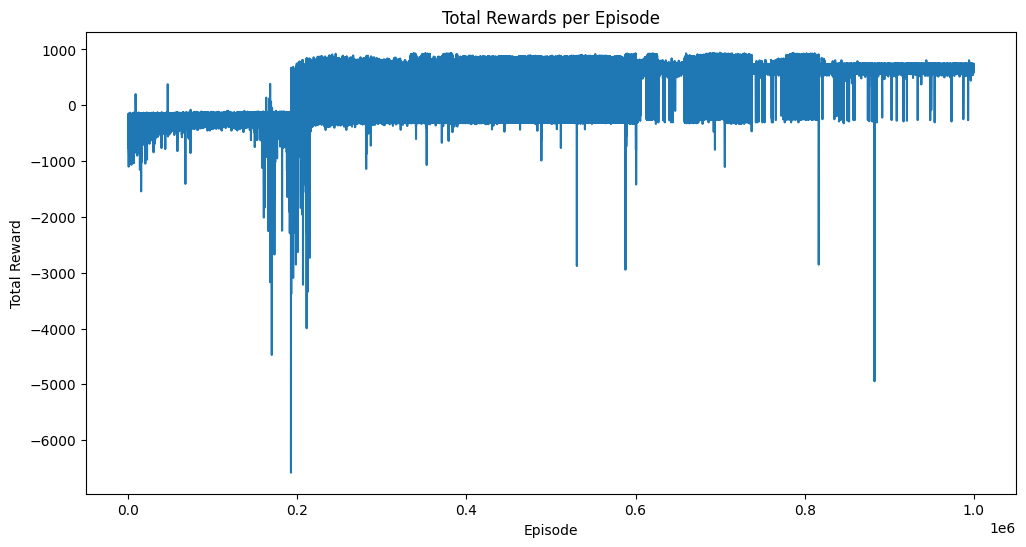

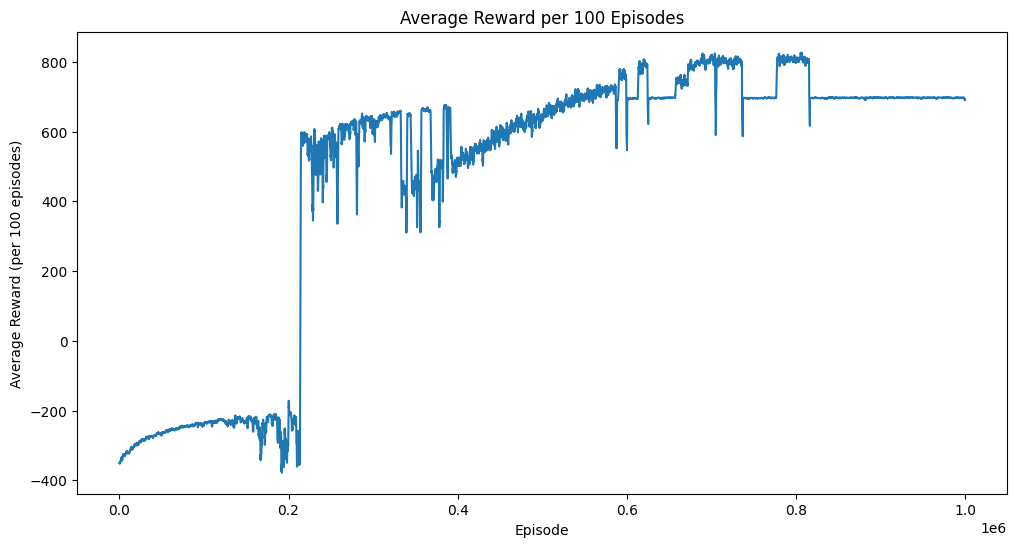

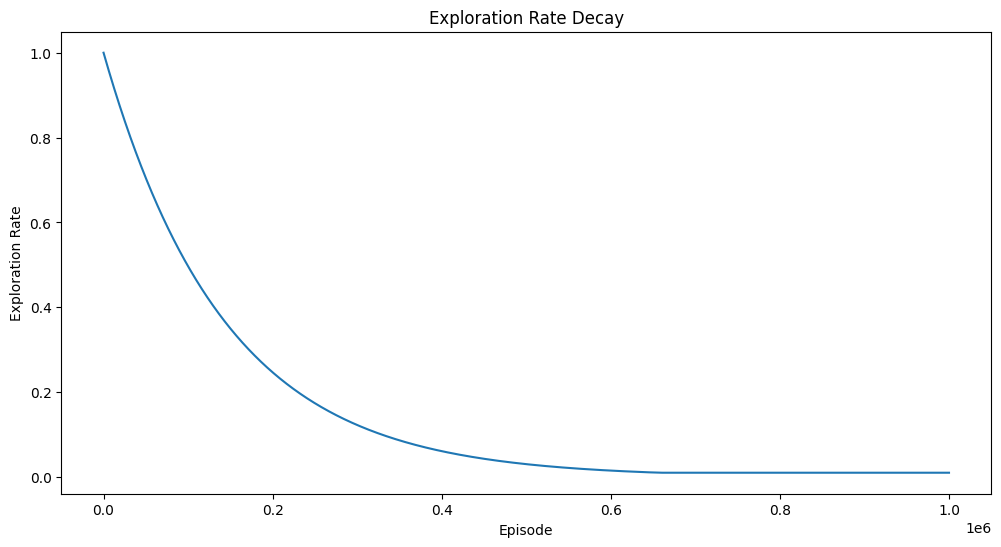

Final Total Reward: 698
Max Reward attained: 941
Average Reward: 469.16854
Average Reward(Last 1000 episodes): 695.946
Standard deviation(Last 1000 episodes):18.849378875708346


In [31]:
class TripleQLearningAgent:
    def __init__(
        self,
        env,
        learning_rate=0.08,
        discount_factor=0.90,
        exploration_rate=1.0,
        exploration_decay=0.999993,
        min_exploration_rate=0.01,
    ):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(4))
        self.q_table2 = defaultdict(lambda: np.zeros(4))
        self.q_table3 = defaultdict(lambda: np.zeros(4))
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])
        else:
            q_values = (
                self.q_table1[state] + self.q_table2[state] + self.q_table3[state]
            )
            return np.argmax(q_values)

    def update_q_tables(self, state, action, reward, next_state):
        update_choice = random.randint(1, 3)
        if update_choice == 1:
            best_next_action = np.argmax(
                self.q_table2[next_state] + self.q_table3[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table2[next_state][best_next_action]
            )
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        elif update_choice == 2:
            best_next_action = np.argmax(
                self.q_table1[next_state] + self.q_table3[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(
                self.q_table1[next_state] + self.q_table2[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table3[state][action]
            self.q_table3[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(
                self.min_exploration_rate,
                self.exploration_rate * self.exploration_decay,
            )

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Rewards per Episode")
        plt.show()

        avg_rewards = [
            np.mean(self.rewards_per_episode[i : i + 1000])
            for i in range(0, len(self.rewards_per_episode), 100)
        ]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Average Reward (per 100 episodes)")
        plt.title("Average Reward per 100 Episodes")
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate")
        plt.title("Exploration Rate Decay")
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)
        avg_last = np.mean(self.rewards_per_episode[-1000:])
        max_reward = np.max(self.rewards_per_episode)
        std_dev = np.std(self.rewards_per_episode[-1000:])

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Max Reward attained: {max_reward}")
        print(f"Average Reward: {average_reward}")
        print(f"Average Reward(Last 1000 episodes): {avg_last}")
        print(f"Standard deviation(Last 1000 episodes):{std_dev}")


env = ComplexPlatformEnv()
agent = TripleQLearningAgent(env)
agent.train(episodes=1000000)
agent.plot_performance()

Episode 1000: Total Reward: -343
Episode 2000: Total Reward: -329
Episode 3000: Total Reward: -269
Episode 4000: Total Reward: -301
Episode 5000: Total Reward: -239
Episode 6000: Total Reward: -363
Episode 7000: Total Reward: -328
Episode 8000: Total Reward: -375
Episode 9000: Total Reward: -426
Episode 10000: Total Reward: -292
Episode 11000: Total Reward: -474
Episode 12000: Total Reward: -310
Episode 13000: Total Reward: -315
Episode 14000: Total Reward: -238
Episode 15000: Total Reward: -231
Episode 16000: Total Reward: -195
Episode 17000: Total Reward: -333
Episode 18000: Total Reward: -229
Episode 19000: Total Reward: -319
Episode 20000: Total Reward: -330
Episode 21000: Total Reward: -295
Episode 22000: Total Reward: -307
Episode 23000: Total Reward: -321
Episode 24000: Total Reward: -322
Episode 25000: Total Reward: -168
Episode 26000: Total Reward: -349
Episode 27000: Total Reward: -252
Episode 28000: Total Reward: -257
Episode 29000: Total Reward: -209
Episode 30000: Total Re

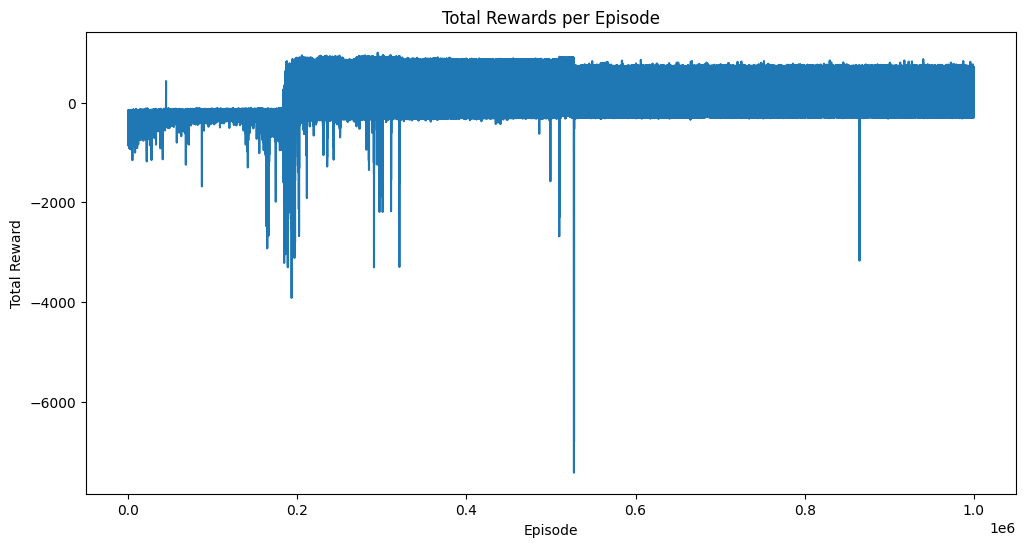

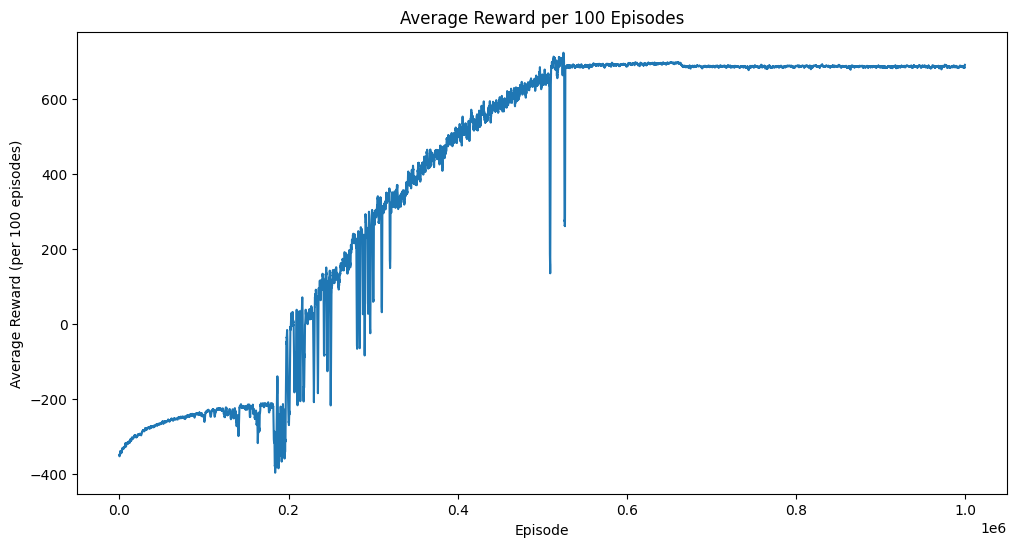

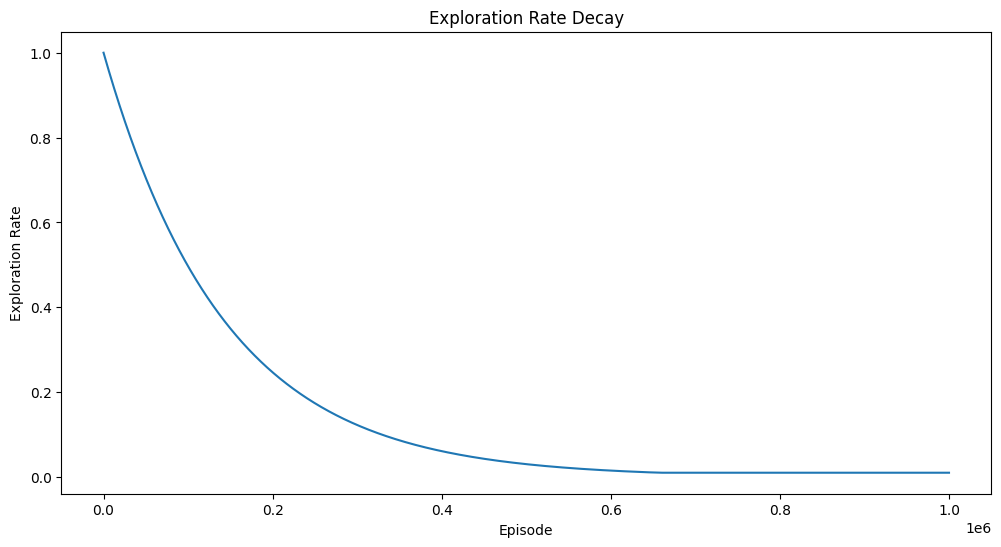

Final Total Reward: 684
Max Reward attained: 1001
Average Reward: 395.342572
Average Reward(Last 1000 episodes): 683.421
Standard deviation(Last 1000 episodes):62.176874792803794


In [32]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import time


class QuadrupleQLearningAgent:
    def __init__(
        self,
        env,
        learning_rate=0.08,
        discount_factor=0.90,
        exploration_rate=1.0,
        exploration_decay=0.999993,
        min_exploration_rate=0.01,
    ):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(4))
        self.q_table2 = defaultdict(lambda: np.zeros(4))
        self.q_table3 = defaultdict(lambda: np.zeros(4))
        self.q_table4 = defaultdict(lambda: np.zeros(4))
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])
        else:
            q_values = (
                self.q_table1[state]
                + self.q_table2[state]
                + self.q_table3[state]
                + self.q_table4[state]
            )
            return np.argmax(q_values)

    def update_q_tables(self, state, action, reward, next_state):
        update_choice = random.randint(1, 4)
        if update_choice == 1:
            best_next_action = np.argmax(
                self.q_table2[next_state]
                + self.q_table3[next_state]
                + self.q_table4[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table2[next_state][best_next_action]
            )
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        elif update_choice == 2:
            best_next_action = np.argmax(
                self.q_table1[next_state]
                + self.q_table3[next_state]
                + self.q_table4[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error
        elif update_choice == 3:
            best_next_action = np.argmax(
                self.q_table1[next_state]
                + self.q_table2[next_state]
                + self.q_table4[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table3[state][action]
            self.q_table3[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(
                self.q_table1[next_state]
                + self.q_table2[next_state]
                + self.q_table3[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table4[state][action]
            self.q_table4[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(
                self.min_exploration_rate,
                self.exploration_rate * self.exploration_decay,
            )

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Rewards per Episode")
        plt.show()

        avg_rewards = [
            np.mean(self.rewards_per_episode[i : i + 1000])
            for i in range(0, len(self.rewards_per_episode), 100)
        ]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Average Reward (per 100 episodes)")
        plt.title("Average Reward per 100 Episodes")
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate")
        plt.title("Exploration Rate Decay")
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)
        avg_last = np.mean(self.rewards_per_episode[-1000:])
        max_reward = np.max(self.rewards_per_episode)
        std_dev = np.std(self.rewards_per_episode[-1000:])

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Max Reward attained: {max_reward}")
        print(f"Average Reward: {average_reward}")
        print(f"Average Reward(Last 1000 episodes): {avg_last}")
        print(f"Standard deviation(Last 1000 episodes):{std_dev}")

env = ComplexPlatformEnv()
agent = QuadrupleQLearningAgent(env)
agent.train(episodes=1000000)
agent.plot_performance()

Episode 1000: Total Reward: -236
Episode 2000: Total Reward: -245
Episode 3000: Total Reward: -240
Episode 4000: Total Reward: -202
Episode 5000: Total Reward: -257
Episode 6000: Total Reward: -313
Episode 7000: Total Reward: -188
Episode 8000: Total Reward: -287
Episode 9000: Total Reward: -210
Episode 10000: Total Reward: -183
Episode 11000: Total Reward: -208
Episode 12000: Total Reward: -218
Episode 13000: Total Reward: -337
Episode 14000: Total Reward: -172
Episode 15000: Total Reward: -221
Episode 16000: Total Reward: -326
Episode 17000: Total Reward: -259
Episode 18000: Total Reward: -232
Episode 19000: Total Reward: -131
Episode 20000: Total Reward: -207
Episode 21000: Total Reward: -284
Episode 22000: Total Reward: -309
Episode 23000: Total Reward: -191
Episode 24000: Total Reward: -286
Episode 25000: Total Reward: -205
Episode 26000: Total Reward: -195
Episode 27000: Total Reward: -190
Episode 28000: Total Reward: -279
Episode 29000: Total Reward: -176
Episode 30000: Total Re

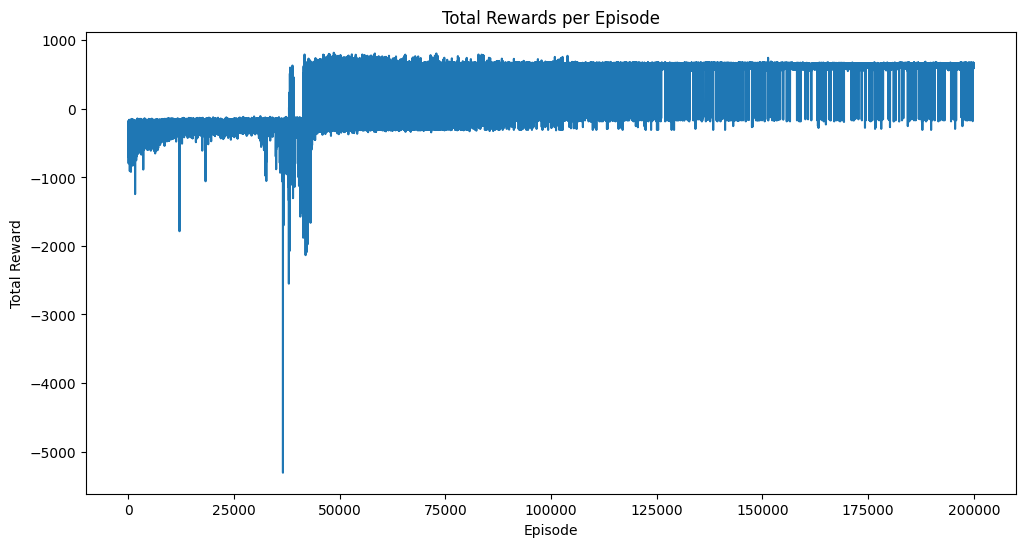

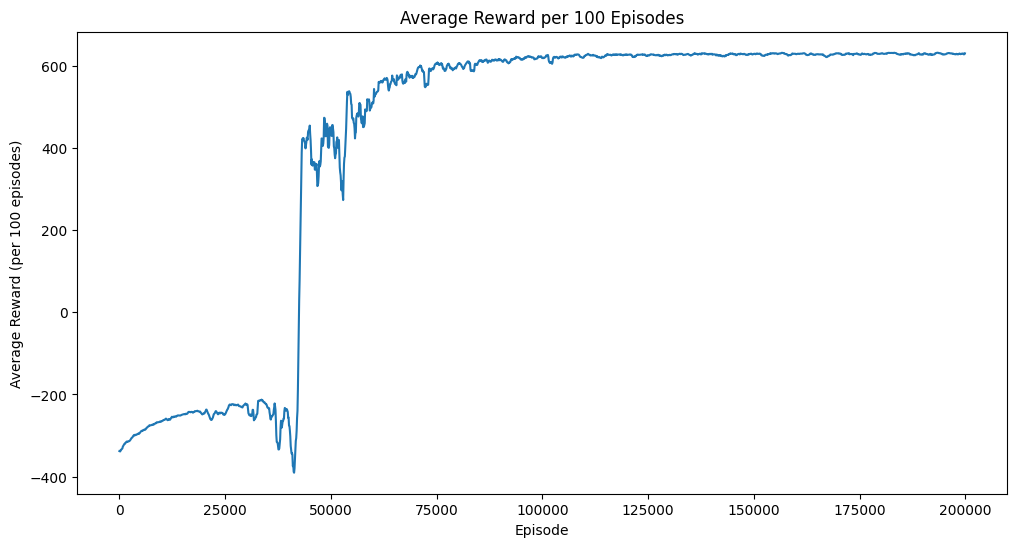

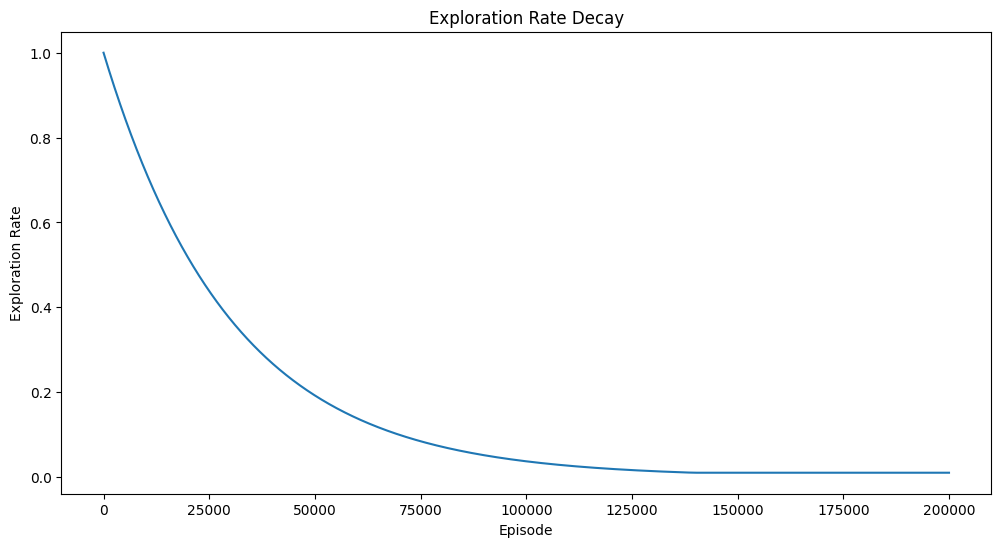

Final Total Reward: 618
Max Reward attained: 820
Average Reward: 412.01839
Average Reward(Last 1000 episodes): 629.178
Standard deviation(Last 1000 episodes):46.2648929102835
Q-table saved to final_q_values.pkl
Rewards saved to rewards_per_episode.pkl


In [33]:
from collections import defaultdict
import pickle
import time


class QLearningAgent:
    def __init__(
        self,
        env,
        learning_rate=0.08,
        discount_factor=0.90,
        exploration_rate=1.0,
        exploration_decay=0.999967,
        min_exploration_rate=0.01,
    ):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table = defaultdict(
            lambda: np.zeros(4)
        )  # Initialize Q-table with zeros for 4 actions
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])  # Explore
        else:
            return np.argmax(self.q_table[state])  # Exploit

    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = (
            reward + self.discount_factor * self.q_table[next_state][best_next_action]
        )
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_table(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(
                self.min_exploration_rate,
                self.exploration_rate * self.exploration_decay,
            )

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Rewards per Episode")
        plt.show()

        avg_rewards = [
            np.mean(self.rewards_per_episode[i : i + 1000])
            for i in range(0, len(self.rewards_per_episode), 100)
        ]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Average Reward (per 100 episodes)")
        plt.title("Average Reward per 100 Episodes")
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate")
        plt.title("Exploration Rate Decay")
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)
        avg_last=np.mean(self.rewards_per_episode[-1000:])
        max_reward = np.max(self.rewards_per_episode)
        std_dev=np.std(self.rewards_per_episode[-1000:])

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Max Reward attained: {max_reward}")
        print(f"Average Reward: {average_reward}")
        print(f"Average Reward(Last 1000 episodes): {avg_last}")
        print(f"Standard deviation(Last 1000 episodes):{std_dev}")

    def save_q_table(self, filename="q_table.pkl"):
        with open(filename, "wb") as file:
            pickle.dump(
                dict(self.q_table), file
            )  # Convert defaultdict to regular dict for saving
        print(f"Q-table saved to {filename}")

    def save_rewards(self, filename="rewards.pkl"):
        with open(filename, "wb") as file:
            pickle.dump(self.rewards_per_episode, file)
        print(f"Rewards saved to {filename}")


env = ComplexPlatformEnv()
agent = QLearningAgent(env)
agent.train(episodes=200000)
agent.plot_performance()
agent.save_q_table("final_q_values.pkl")
agent.save_rewards("rewards_per_episode.pkl")

Episode 1000: Total Reward: -367
Episode 2000: Total Reward: -248
Episode 3000: Total Reward: -337
Episode 4000: Total Reward: -209
Episode 5000: Total Reward: -266
Episode 6000: Total Reward: -260
Episode 7000: Total Reward: -199
Episode 8000: Total Reward: -192
Episode 9000: Total Reward: -264
Episode 10000: Total Reward: -305
Episode 11000: Total Reward: -280
Episode 12000: Total Reward: -223
Episode 13000: Total Reward: -191
Episode 14000: Total Reward: -364
Episode 15000: Total Reward: -312
Episode 16000: Total Reward: -339
Episode 17000: Total Reward: -305
Episode 18000: Total Reward: -188
Episode 19000: Total Reward: -320
Episode 20000: Total Reward: -313
Episode 21000: Total Reward: -232
Episode 22000: Total Reward: -225
Episode 23000: Total Reward: -266
Episode 24000: Total Reward: -263
Episode 25000: Total Reward: -310
Episode 26000: Total Reward: -224
Episode 27000: Total Reward: -161
Episode 28000: Total Reward: -171
Episode 29000: Total Reward: -178
Episode 30000: Total Re

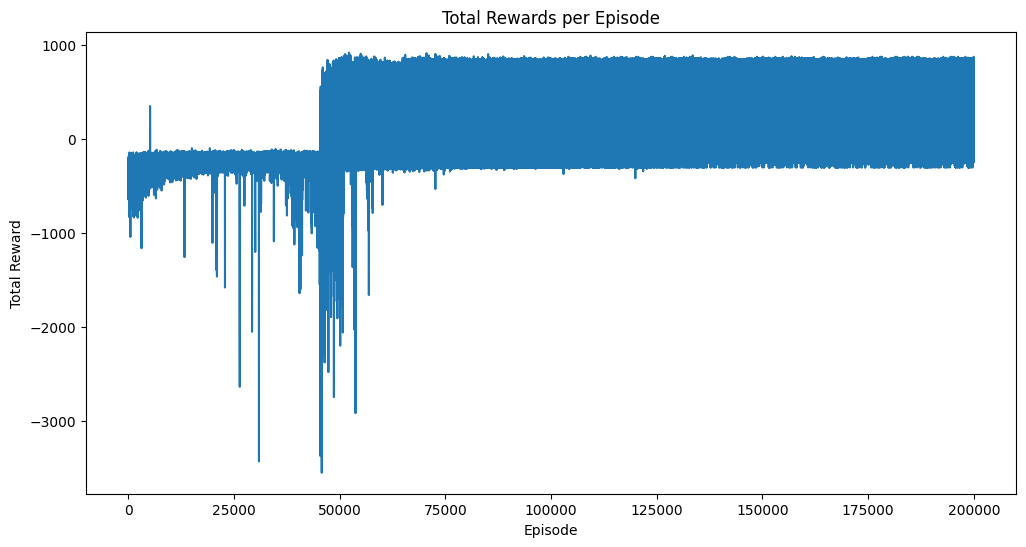

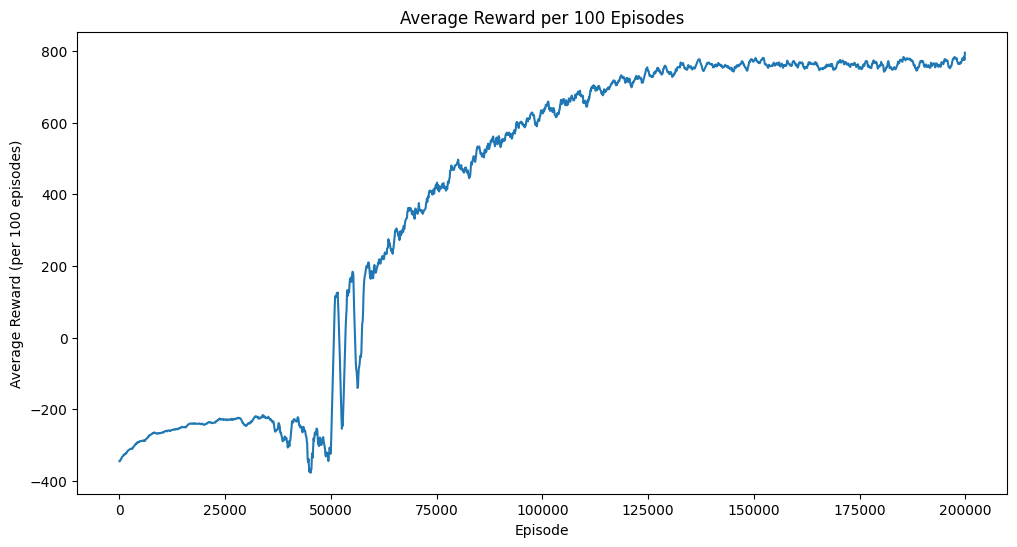

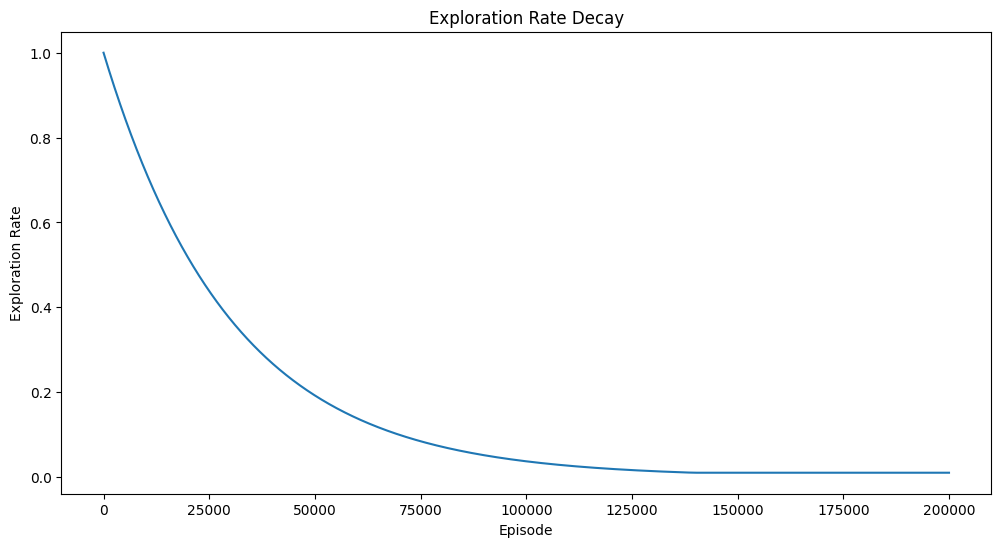

Final Total Reward: 820
Max Reward attained: 914
Average Reward: 393.75407
Average Reward(Last 1000 episodes): 767.232
Standard deviation(Last 1000 episodes):233.21941209084633


In [34]:
class DoubleQLearningAgent:
    def __init__(
        self,
        env,
        learning_rate=0.08,
        discount_factor=0.90,
        exploration_rate=1.0,
        exploration_decay=0.999967,
        min_exploration_rate=0.01,
    ):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(4))
        self.q_table2 = defaultdict(lambda: np.zeros(4))
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])
        else:
            q_values = self.q_table1[state] + self.q_table2[state]
            return np.argmax(q_values)

    def update_q_tables(self, state, action, reward, next_state):
        if random.random() < 0.5:
            best_next_action = np.argmax(self.q_table2[next_state])
            td_target = (
                reward
                + self.discount_factor * self.q_table2[next_state][best_next_action]
            )
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(self.q_table1[next_state])
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(
                self.min_exploration_rate,
                self.exploration_rate * self.exploration_decay,
            )

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Rewards per Episode")
        plt.show()

        avg_rewards = [
            np.mean(self.rewards_per_episode[i : i + 1000])
            for i in range(0, len(self.rewards_per_episode), 100)
        ]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Average Reward (per 100 episodes)")
        plt.title("Average Reward per 100 Episodes")
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate")
        plt.title("Exploration Rate Decay")
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)
        avg_last = np.mean(self.rewards_per_episode[-1000:])
        max_reward = np.max(self.rewards_per_episode)
        std_dev = np.std(self.rewards_per_episode[-1000:])

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Max Reward attained: {max_reward}")
        print(f"Average Reward: {average_reward}")
        print(f"Average Reward(Last 1000 episodes): {avg_last}")
        print(f"Standard deviation(Last 1000 episodes):{std_dev}")


env = ComplexPlatformEnv()
agent = DoubleQLearningAgent(env)
agent.train(episodes=200000)
agent.plot_performance()

Episode 1000: Total Reward: -308
Episode 2000: Total Reward: -240
Episode 3000: Total Reward: -305
Episode 4000: Total Reward: -276
Episode 5000: Total Reward: -311
Episode 6000: Total Reward: -371
Episode 7000: Total Reward: -223
Episode 8000: Total Reward: -276
Episode 9000: Total Reward: -254
Episode 10000: Total Reward: -353
Episode 11000: Total Reward: -271
Episode 12000: Total Reward: -210
Episode 13000: Total Reward: -185
Episode 14000: Total Reward: -322
Episode 15000: Total Reward: -197
Episode 16000: Total Reward: -285
Episode 17000: Total Reward: -120
Episode 18000: Total Reward: -285
Episode 19000: Total Reward: -224
Episode 20000: Total Reward: -335
Episode 21000: Total Reward: -276
Episode 22000: Total Reward: -185
Episode 23000: Total Reward: -260
Episode 24000: Total Reward: -196
Episode 25000: Total Reward: -196
Episode 26000: Total Reward: -191
Episode 27000: Total Reward: -186
Episode 28000: Total Reward: -254
Episode 29000: Total Reward: -158
Episode 30000: Total Re

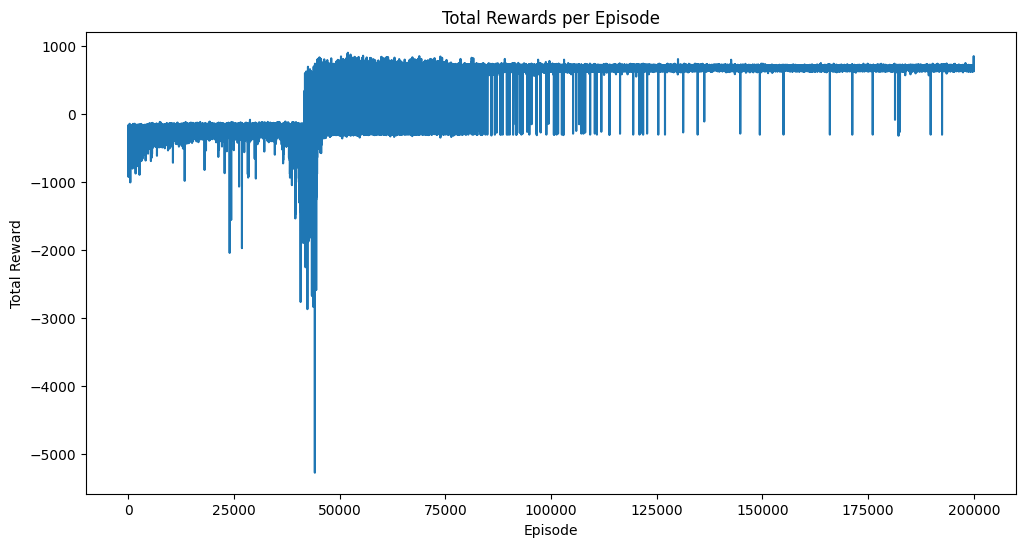

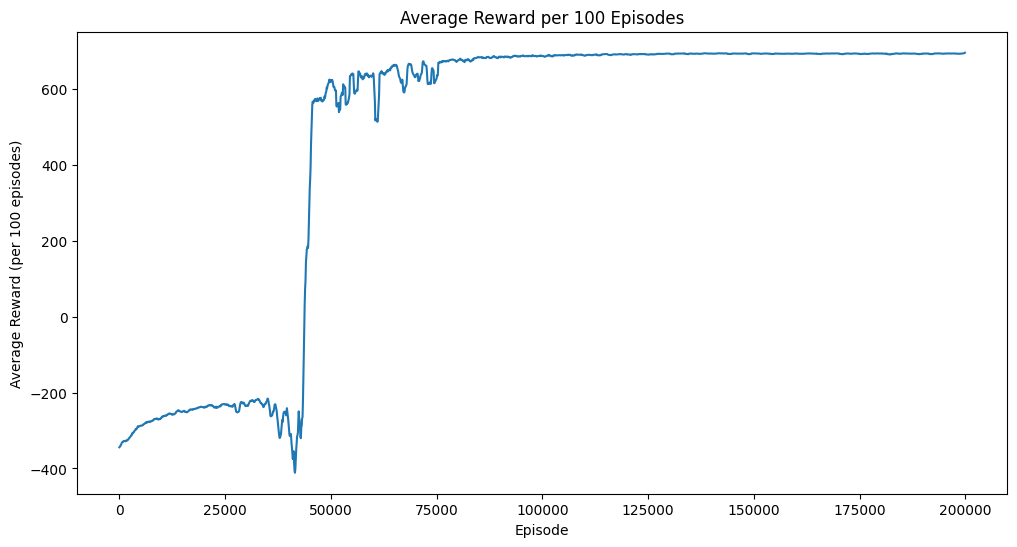

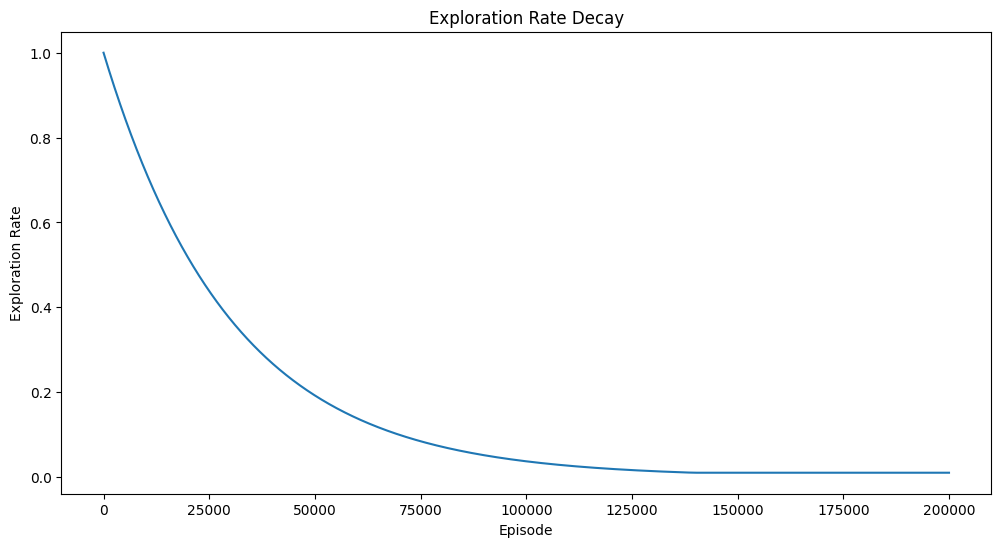

Final Total Reward: 699
Max Reward attained: 898
Average Reward: 464.90671
Average Reward(Last 1000 episodes): 693.302
Standard deviation(Last 1000 episodes):13.099954045720924


In [35]:
class TripleQLearningAgent:
    def __init__(
        self,
        env,
        learning_rate=0.08,
        discount_factor=0.90,
        exploration_rate=1.0,
        exploration_decay=0.999967,
        min_exploration_rate=0.01,
    ):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(4))
        self.q_table2 = defaultdict(lambda: np.zeros(4))
        self.q_table3 = defaultdict(lambda: np.zeros(4))
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])
        else:
            q_values = (
                self.q_table1[state] + self.q_table2[state] + self.q_table3[state]
            )
            return np.argmax(q_values)

    def update_q_tables(self, state, action, reward, next_state):
        update_choice = random.randint(1, 3)
        if update_choice == 1:
            best_next_action = np.argmax(
                self.q_table2[next_state] + self.q_table3[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table2[next_state][best_next_action]
            )
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        elif update_choice == 2:
            best_next_action = np.argmax(
                self.q_table1[next_state] + self.q_table3[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(
                self.q_table1[next_state] + self.q_table2[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table3[state][action]
            self.q_table3[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(
                self.min_exploration_rate,
                self.exploration_rate * self.exploration_decay,
            )

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Rewards per Episode")
        plt.show()

        avg_rewards = [
            np.mean(self.rewards_per_episode[i : i + 1000])
            for i in range(0, len(self.rewards_per_episode), 100)
        ]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Average Reward (per 100 episodes)")
        plt.title("Average Reward per 100 Episodes")
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate")
        plt.title("Exploration Rate Decay")
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)
        avg_last = np.mean(self.rewards_per_episode[-1000:])
        max_reward = np.max(self.rewards_per_episode)
        std_dev = np.std(self.rewards_per_episode[-1000:])

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Max Reward attained: {max_reward}")
        print(f"Average Reward: {average_reward}")
        print(f"Average Reward(Last 1000 episodes): {avg_last}")
        print(f"Standard deviation(Last 1000 episodes):{std_dev}")


env = ComplexPlatformEnv()
agent = TripleQLearningAgent(env)
agent.train(episodes=200000)
agent.plot_performance()

Episode 1000: Total Reward: -285
Episode 2000: Total Reward: -340
Episode 3000: Total Reward: -260
Episode 4000: Total Reward: -309
Episode 5000: Total Reward: -269
Episode 6000: Total Reward: -233
Episode 7000: Total Reward: -175
Episode 8000: Total Reward: -291
Episode 9000: Total Reward: -311
Episode 10000: Total Reward: -245
Episode 11000: Total Reward: -246
Episode 12000: Total Reward: -293
Episode 13000: Total Reward: -265
Episode 14000: Total Reward: -158
Episode 15000: Total Reward: -251
Episode 16000: Total Reward: -322
Episode 17000: Total Reward: -292
Episode 18000: Total Reward: -160
Episode 19000: Total Reward: -246
Episode 20000: Total Reward: -315
Episode 21000: Total Reward: -182
Episode 22000: Total Reward: -298
Episode 23000: Total Reward: -259
Episode 24000: Total Reward: -261
Episode 25000: Total Reward: -193
Episode 26000: Total Reward: -147
Episode 27000: Total Reward: -176
Episode 28000: Total Reward: -302
Episode 29000: Total Reward: -247
Episode 30000: Total Re

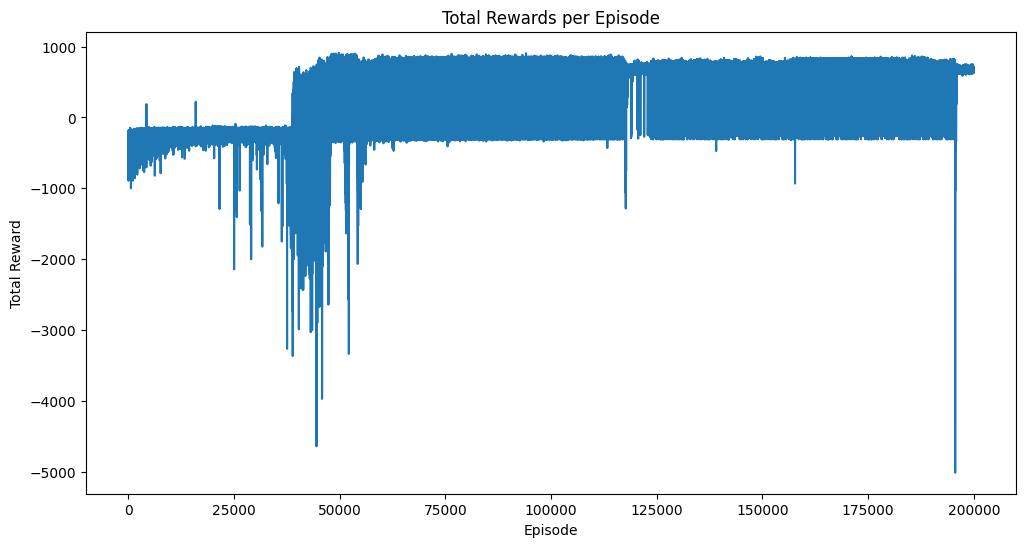

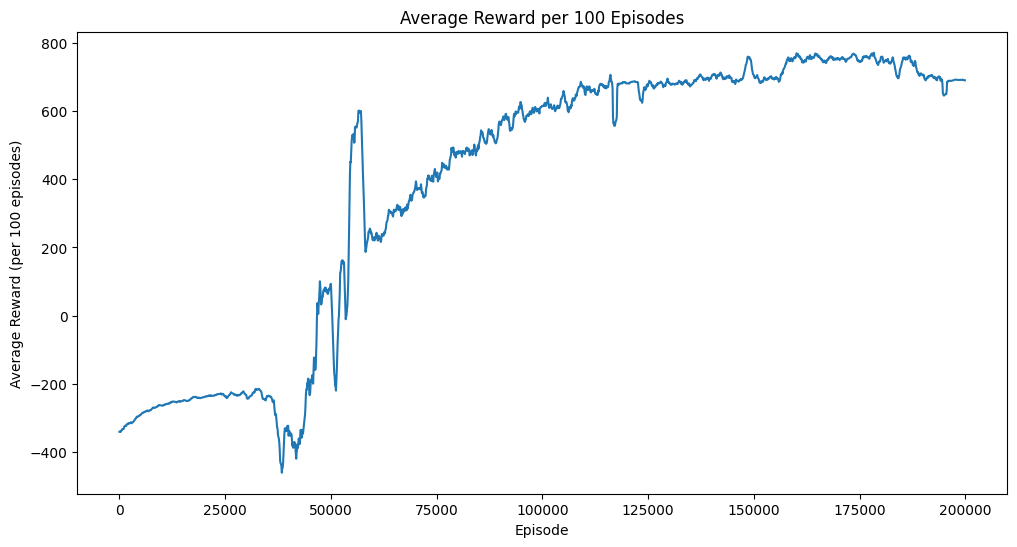

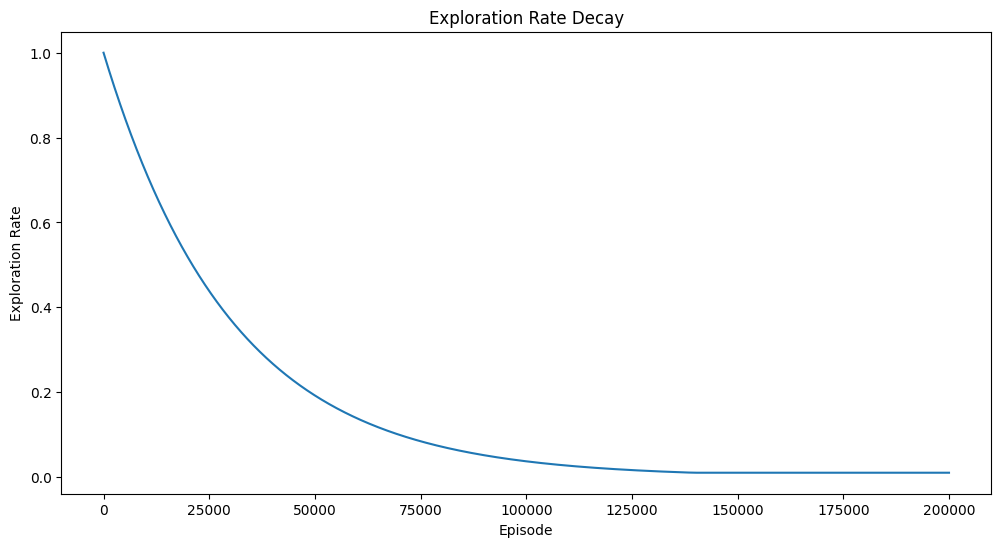

Final Total Reward: 714
Max Reward attained: 914
Average Reward: 388.62461
Average Reward(Last 1000 episodes): 691.867
Standard deviation(Last 1000 episodes):15.293636290954483


In [36]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import time


class QuadrupleQLearningAgent:
    def __init__(
        self,
        env,
        learning_rate=0.08,
        discount_factor=0.90,
        exploration_rate=1.0,
        exploration_decay=0.999967,
        min_exploration_rate=0.01,
    ):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        self.q_table1 = defaultdict(lambda: np.zeros(4))
        self.q_table2 = defaultdict(lambda: np.zeros(4))
        self.q_table3 = defaultdict(lambda: np.zeros(4))
        self.q_table4 = defaultdict(lambda: np.zeros(4))
        self.rewards_per_episode = []
        self.exploration_rates = []

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])
        else:
            q_values = (
                self.q_table1[state]
                + self.q_table2[state]
                + self.q_table3[state]
                + self.q_table4[state]
            )
            return np.argmax(q_values)

    def update_q_tables(self, state, action, reward, next_state):
        update_choice = random.randint(1, 4)
        if update_choice == 1:
            best_next_action = np.argmax(
                self.q_table2[next_state]
                + self.q_table3[next_state]
                + self.q_table4[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table2[next_state][best_next_action]
            )
            td_error = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.learning_rate * td_error
        elif update_choice == 2:
            best_next_action = np.argmax(
                self.q_table1[next_state]
                + self.q_table3[next_state]
                + self.q_table4[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.learning_rate * td_error
        elif update_choice == 3:
            best_next_action = np.argmax(
                self.q_table1[next_state]
                + self.q_table2[next_state]
                + self.q_table4[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table3[state][action]
            self.q_table3[state][action] += self.learning_rate * td_error
        else:
            best_next_action = np.argmax(
                self.q_table1[next_state]
                + self.q_table2[next_state]
                + self.q_table3[next_state]
            )
            td_target = (
                reward
                + self.discount_factor * self.q_table1[next_state][best_next_action]
            )
            td_error = td_target - self.q_table4[state][action]
            self.q_table4[state][action] += self.learning_rate * td_error

    def train(self, episodes=2000):
        start_time = time.time()

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0

            while True:
                action = self.choose_action(state)
                next_state, reward, done = self.env.step(action)
                self.update_q_tables(state, action, reward, next_state)
                state = next_state
                total_reward += reward

                if done:
                    break

            self.rewards_per_episode.append(total_reward)
            self.exploration_rates.append(self.exploration_rate)
            self.exploration_rate = max(
                self.min_exploration_rate,
                self.exploration_rate * self.exploration_decay,
            )

            if (episode + 1) % 1000 == 0:
                print(f"Episode {episode + 1}: Total Reward: {total_reward}")

        end_time = time.time()
        training_time = end_time - start_time
        print(f"Training completed in {training_time:.2f} seconds.")

    def plot_performance(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.rewards_per_episode)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Total Rewards per Episode")
        plt.show()

        avg_rewards = [
            np.mean(self.rewards_per_episode[i : i + 1000])
            for i in range(0, len(self.rewards_per_episode), 100)
        ]
        plt.figure(figsize=(12, 6))
        plt.plot(range(0, len(self.rewards_per_episode), 100), avg_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Average Reward (per 100 episodes)")
        plt.title("Average Reward per 100 Episodes")
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.exploration_rates)
        plt.xlabel("Episode")
        plt.ylabel("Exploration Rate")
        plt.title("Exploration Rate Decay")
        plt.show()

        final_total_reward = self.rewards_per_episode[-1]
        average_reward = np.mean(self.rewards_per_episode)
        avg_last = np.mean(self.rewards_per_episode[-1000:])
        max_reward = np.max(self.rewards_per_episode)
        std_dev = np.std(self.rewards_per_episode[-1000:])

        print(f"Final Total Reward: {final_total_reward}")
        print(f"Max Reward attained: {max_reward}")
        print(f"Average Reward: {average_reward}")
        print(f"Average Reward(Last 1000 episodes): {avg_last}")
        print(f"Standard deviation(Last 1000 episodes):{std_dev}")


env = ComplexPlatformEnv()
agent = QuadrupleQLearningAgent(env)
agent.train(episodes=200000)
agent.plot_performance()